# Lab Assignment Seven: Recurrent Network Architectures

### By Malgorzata Z. Makos and Richa Mahajan

### Bussiness understanding
Twitter, the most popular microblogging service was launched in 2006, its co-founder (at that time an undergraduate student at New York University)  Jack Dorsey described Twitter as "the SMS of the Internet". Tweets were originally restricted to 140 characters, but in 2017, this limit was doubled to 280. Many times tweets express opinions about different topics.  Tweets are different from reviews primarily because of their purpose: while reviews represent summarized thoughts of authors, tweets are more casual and generally not as thoughtfully composed as reviews. Yet, they still offer companies an additional avenue to gather feedback and show the polarity of the opinions. 

### Data Set Overview
Our data set contain together around half-million tweets sentimentally classified as either positive or negative.  Data were collected in 2009, therefore, are limited to 140 characters. The data are available on the Kaggle.com

### The purpose of the Data Set
Sentiment analysis is becoming a popular area of research and social media analysis, especially around tweets. It is a special case of text mining generally focused on identifying opinion polarity. Classifying tweets into positive or negative is important for many reasons. Consumers can use sentiment analysis to research products or services before making a purchase. Marketers can use this to research public opinion of their company and products, or to analyze customer satisfaction. Organizations can also use this to gather critical feedback about problems in newly released products. 

### Programming part
Based on Dr. Eric Larson's course at SMU, Fall 2019, https://github.com/eclarson/MachineLearningNotebooks

In [1]:
import pandas as pd
import numpy as np
from scipy.special import expit
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn import preprocessing
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import timeit
import csv
import warnings
warnings.filterwarnings("ignore")
from sklearn.utils import resample
from sklearn.model_selection import StratifiedKFold

In [2]:
df = pd.read_csv('tweets_500000.csv')
df.head()

,target,ids,date,flag,user,text
0,4,1467822273,Mon Apr 06 22:22:45 PDT 2009,NO_QUERY,becca210,im meeting up with one of my besties tonight! ...
1,4,1467822283,Mon Apr 06 22:22:46 PDT 2009,NO_QUERY,Wingman29,"@DaRealSunisaKim Thanks for the Twitter add, S..."
2,4,1467822287,Mon Apr 06 22:22:46 PDT 2009,NO_QUERY,katarinka,Being sick can be really cheap when it hurts t...
3,4,1467822293,Mon Apr 06 22:22:46 PDT 2009,NO_QUERY,_EmilyYoung,@LovesBrooklyn2 he has that effect on everyone
4,4,1467822391,Mon Apr 06 22:22:47 PDT 2009,NO_QUERY,ajarofalmonds,@ProductOfFear You can tell him that I just bu...


Provided data set is basically "ready to use". Here we will focus on the polarity of the tweet, which is described in the "target" column (0 = negative, 4 = positive) and on the tweets, users created status messages, that are in the "text" column.

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 497150 entries, 0 to 497149
Data columns (total 6 columns):
target    497150 non-null int64
ids       497150 non-null int64
date      497150 non-null object
flag      497150 non-null object
user      497150 non-null object
text      497150 non-null object
dtypes: int64(2), object(4)
memory usage: 22.8+ MB


In [4]:
df.shape

(497150, 6)

In [5]:
def count_unique(df, cols):
    for col in cols:
        print('\n' + 'For column ' + col)
        print(df[col].value_counts())

cat_cols = ["target"]
count_unique(df, cat_cols)


For column target
4    248575
0    248575
Name: target, dtype: int64


We can see that our data are balanced with the same number of positive and negative tweets. 

In [6]:
X = df.text
y = df.target

#print ([y=='Nan'])
for i in y:
    if i == 'NaN':
        print (i)

le = preprocessing.LabelEncoder()
y = le.fit(y).transform(y)

print (len(X),len(y))
print (le.classes_)

497150 497150
[0 4]


In [7]:
import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import numpy as np


NUM_TOP_WORDS = None
MAX_ART_LEN = 100 # maximum number of words for each text

tokenizer = Tokenizer(num_words=NUM_TOP_WORDS)
tokenizer.fit_on_texts(X)
sequences = tokenizer.texts_to_sequences(X)

word_index = tokenizer.word_index
NUM_TOP_WORDS = len(word_index) if NUM_TOP_WORDS==None else NUM_TOP_WORDS
top_words = min((len(word_index),NUM_TOP_WORDS))
print('Found %s unique tokens. Distilled to %d top words.' % (len(word_index),top_words))

X = pad_sequences(sequences, maxlen=MAX_ART_LEN)

y_ohe = keras.utils.to_categorical(y)
print('Shape of data tensor:', X.shape)
print('Shape of label tensor:', y_ohe.shape)
print(np.max(X))

Using TensorFlow backend.


Found 295777 unique tokens. Distilled to 295777 top words.
Shape of data tensor: (497150, 100)
Shape of label tensor: (497150, 2)
295777


In [8]:
from sklearn.model_selection import train_test_split
# Split it into train / test subsets
X_train, X_test, y_train_ohe, y_test_ohe = train_test_split(X, y_ohe, test_size=0.2)
NUM_CLASSES = y_ohe.shape[1]
n_classes = NUM_CLASSES
#print (y_ohe)
print ('Number of classes',y_ohe.shape[1])
print(X_train.shape,y_train_ohe.shape)
print(np.sum(y_train_ohe,axis=0))

Number of classes 2
(397720, 100) (397720, 2)
[198903. 198817.]


In [9]:
y_test = np.round(np.argmax(y_test_ohe,axis=1))
y_train = np.round(np.argmax(y_train_ohe,axis=1))

In [10]:
%%time
EMBED_SIZE = 100
# the embed size should match the file you load glove from
embeddings_index = {}
f = open('glove.6B.100d.txt','r', encoding = 'utf8')
# save key/array pairs of the embeddings
#  the key of the dictionary is the word, the array is the embedding
name = []
for line in f:
    values = line.split()
    word = values[0]
    name.append(word)
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

# now fill in the matrix, using the ordering from the
#  keras word tokenizer from before
embedding_matrix = np.zeros((len(word_index) + 1, EMBED_SIZE))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

print(embedding_matrix.shape)

Found 400000 word vectors.
(295778, 100)
CPU times: user 20.5 s, sys: 900 ms, total: 21.4 s
Wall time: 22.3 s


In [11]:
from keras.layers import Embedding

embedding_layer = Embedding(len(word_index) + 1,
                            EMBED_SIZE,
                            weights=[embedding_matrix],
                            input_length=MAX_ART_LEN,
                            trainable=False)

In [12]:
from sklearn import metrics as mt
from matplotlib import pyplot as plt
from skimage.io import imshow
import seaborn as sns
from keras.models import Sequential
from keras.layers import Reshape
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping
from keras.regularizers import l2
from keras.layers import average 
from keras.models import Input, Model
from keras.layers import average, concatenate
from keras.models import Input, Model
from keras.callbacks import EarlyStopping
from keras.regularizers import l2 
from sklearn.metrics import accuracy_score
from keras.models import Sequential
from keras.layers import Dense, Activation, Input, Dropout
from keras.layers import Embedding, Flatten, concatenate
from keras.models import Model
from sklearn import metrics as mt
from sklearn.preprocessing import OneHotEncoder
from keras import backend as K
from sklearn.model_selection import StratifiedKFold
%matplotlib inline

def summarize_net(net, X_test, y_test, title_text=''):
    plt.figure(figsize=(15,5))
    yhat = np.argmax(net.predict(X_test), axis=1)
    #print (y_test.shape,yhat.shape)
    acc = mt.accuracy_score(y_test,yhat)
    cm = mt.confusion_matrix(y_test,yhat)
    cm = cm/np.sum(cm,axis=1)[:,np.newaxis]
    sns.heatmap(cm, annot=True, fmt='.2f')
    plt.title(title_text+'{:.4f}'.format(acc))
    return cm

## Metric measurement
Our dataset has 2 classes of tweets. It shows the sentiment of the tweets, whether a tweet is positive or negative.
When building a good model it is very necessary to evaluate the performance of the model using a correct metric. There are various metrics that we can use to evaluate the performance of our model. Some of the metrics we can use are Accuracy, Precision, Recall, F1 score. Accuracy gives us the evaluation based on how many times our model is correctly classifying the data. Precision gives us the ratio of true positives to the sum of true positives and false positives. The recall is similar to precision, but it is the ratio of true positives to the sum of true positives and false negatives. If we want to get the evaluation of false positives and false negatives together then the F1 score can be used.
<br>

For our dataset, we are trying to classify the tweets according to their sentiment. In this case, we are not interested in the outcome of a specific class more than the others. So we are not interested in knowing exactly how many false positives and false negatives our model predicts. We want to know how many times our model is predicting correctly. Both classes are equally important in our prediction algorithm. <br>

Considering the above case, we will use accuracy as the metric so that we can evaluate the performance of our model for the overall dataset. We want to find how many tweets are being predicted correctly. So to give equal importance to both the classes, we think Accuracy is the best metric. In addition, our data set contains almost half-million data, they are balanced with the same number of positive and negative tweets, therefore accuracy will be a valid metric for our data set. 


## Cross validation method - Train/Test Split
As mentioned before, we work on a huge data set that contains 497150 tweets, divided according to their sentiment into positive or negative. This gives us a "green light" to use the shuffle split in the 80/20 manner, where 80% of our data are train and 20% test data. In the cells above, we have loaded in the data, split it into training and testing sets. In the modeling part, we fitted various Recurrent Neural Network models, made predictions based on this data and tested the predictions on the test data. Because our data set is balanced in terms of classes we do not have to be worry that the split will be uneven and have more data from any one class than the other. Also due to the large amount of data, the model will not be overfitted.

## Modeling

In [13]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

In [16]:
from sklearn.metrics import f1_score
def arch1_type1(X_train,X_test,y_train_ohe,y_test_ohe,v,e):
    rnn = Sequential()
    rnn.add(embedding_layer)
    rnn.add(LSTM(100,dropout=0.2, recurrent_dropout=0.2))
    rnn.add(Dense(NUM_CLASSES, activation='sigmoid'))

    # Let's train the model 
    rnn.compile(loss='binary_crossentropy',
                  optimizer='Adam',
                  metrics=['accuracy'])

    bath_size = 32
    history = rnn.fit(X_train, y_train_ohe, batch_size=32, 
                      epochs=e, verbose=v,
                      validation_data=(X_test,y_test_ohe),# validation_steps=1,
                      callbacks=[EarlyStopping(monitor='val_loss', patience=3)]
                     )
    pred = np.round(np.argmax(rnn.predict(X_test),axis=1))
    c = accuracy_score(np.round(np.argmax(y_test_ohe,axis =1)), pred)
    f1 = f1_score(np.round(np.argmax(y_test_ohe,axis =1)), pred)
    
    result = np.round(rnn.predict(X_test))
    
    return history,rnn,c,f1,pred, result

In [ ]:
#This takes a lot of time to run so we have saved the output in a file - see below
history_1,model_1,c_1,f1_1,pred_1, result1 = arch1_type1(X_train,X_test,y_train_ohe,y_test_ohe,1,20) # last two are verbose and epochs
#model_1.summary()

In [17]:
import pickle
h = open('model_1.pickle','rb')
results = pickle.load(h)
history_1,model_1,c_1,f1_1,pred_1, result1 = results

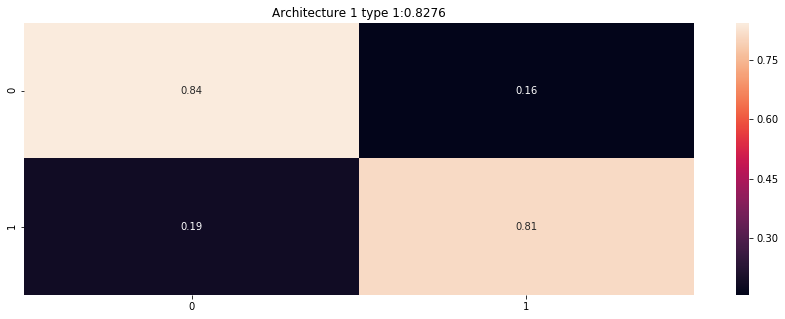

In [18]:
cm1 = summarize_net(model_1, X_test, y_test, title_text='Architecture 1 type 1:')

### Architecture 1 type 2

In [19]:
def arch1_type2(X_train,X_test,y_train_ohe,y_test_ohe,v,e):
    rnn = Sequential()
    rnn.add(embedding_layer)
    rnn.add(LSTM(100,dropout=0.2, recurrent_dropout=0.2))
    rnn.add(Dense(100, activation='relu'))
    rnn.add(Dense(NUM_CLASSES, activation='sigmoid'))

    # Let's train the model 
    rnn.compile(loss='binary_crossentropy',
                  optimizer='Adam',
                  metrics=['accuracy'])

    batch_size = 32
    history = rnn.fit(X_train, y_train_ohe, batch_size=32, 
                      epochs=e, verbose=v,
                      validation_data=(X_test,y_test_ohe),# validation_steps=1,
                      callbacks=[EarlyStopping(monitor='val_loss', patience=3)]
                     )
    pred = np.round(np.argmax(rnn.predict(X_test),axis=1))
    c = accuracy_score(np.round(np.argmax(y_test_ohe,axis =1)), pred)
    f1 = f1_score(np.round(np.argmax(y_test_ohe,axis =1)), pred)
    
    result = np.round(rnn.predict(X_test))
    
    return history,rnn,c,f1,pred, result

In [ ]:
# This cell ran on diferent machine
history_1_type_2,model_1_type_2,c_1_type_2,f1_1_type_2,pred_1_type_2, result1_type_2 = arch1_type2(X_train,X_test,y_train_ohe,y_test_ohe,1,20)


In [20]:
import pickle
h = open('model_1_type_2.pickle','rb')
results = pickle.load(h)
history_1_type_2,model_1_type_2,c_1_type_2,f1_1_type_2,pred_1_type_2, result1_type_2 = results

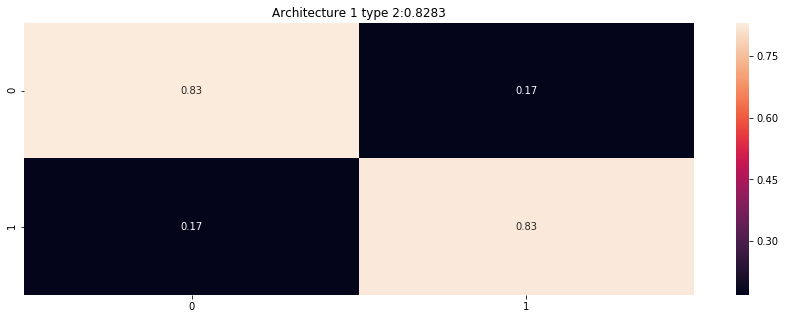

In [21]:
cm1_type2 = summarize_net(model_1_type_2, X_test, y_test, title_text='Architecture 1 type 2:')

### Visualizing the performance using ROC and AUC

In [22]:
print(__doc__)
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle
from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp

Automatically created module for IPython interactive environment


In [ ]:
costs_1 = []
costs_1_type2 = []
ref = 1

fpr_arch1 = []
tpr_arch1 = []
roc_auc_macro_arch1 = []
fpr_all_arch1 = []
tpr_all_arch1 = []
roc_auc_macro_all_arch1 = []
fpr_arch1_type2 = []
tpr_arch1_type2 = []
roc_auc_macro_arch1_type2 = []
fpr_all_arch1_type2 = []
tpr_all_arch1_type2 = []
roc_auc_macro_all_arch1_type2 = []

X_train_temp = X_train
y_train_temp = keras.utils.to_categorical(y_train, n_classes)
X_test_temp = X_test
y_test_temp = keras.utils.to_categorical(y_test, n_classes)

# take cost
history,model,c,f1,pred,result = arch1_type1(X_train_temp,X_test_temp,y_train_temp,y_test_temp,1,1) # last two are verbose and epochs
costs_1.append(c)
print(mt.confusion_matrix(np.round(np.argmax(y_test_temp,axis =1)),pred), "=>", c)

history_1_type_2,model_1_type_2,c_1_type_2,f1_1_type_2,pred_1_type_2, result1_type_2 = arch1_type2(X_train_temp,X_test_temp,y_train_temp,y_test_temp,1,1) # last two are verbose and epochs
costs_1_type2.append(c_1_type_2)
# print confusion matrix
print(mt.confusion_matrix(np.round(np.argmax(y_test_temp,axis =1)),pred_1_type_2), "=>", c_1_type_2)

#ROC
y_score =result
y_score1_type2 = result1_type_2

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_temp[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_temp.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
fpr_arch1.append(fpr["micro"])
tpr_arch1.append(tpr["micro"])
roc_auc_macro_arch1.append(roc_auc["micro"])
# Compute macro-average ROC curve and ROC area
lw = 3
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])
# Finally average it and compute AUC
mean_tpr /= n_classes
fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])
fpr_all_arch1.append(fpr["macro"])
tpr_all_arch1.append(tpr["macro"])
roc_auc_macro_all_arch1.append(roc_auc["macro"])
ref+=1
print(costs_1)

fpr1_type2 = dict()
tpr1_type2 = dict()
roc_auc1_type2 = dict()
for i in range(n_classes):
    fpr1_type2[i], tpr1_type2[i], _ = roc_curve(y_test_temp[:, i], y_score1_type2[:, i])
    roc_auc1_type2[i] = auc(fpr1_type2[i], tpr1_type2[i])
# Compute micro-average ROC curve and ROC area
fpr1_type2["micro"], tpr1_type2["micro"], _ = roc_curve(y_test_temp.ravel(), y_score1_type2.ravel())
roc_auc1_type2["micro"] = auc(fpr1_type2["micro"], tpr1_type2["micro"])
fpr_arch1_type2.append(fpr1_type2["micro"])
tpr_arch1_type2.append(tpr1_type2["micro"])
roc_auc_macro_arch1_type2.append(roc_auc1_type2["micro"])
# Compute macro-average ROC curve and ROC area
lw = 3
# First aggregate all false positive rates
all_fpr1_type2 = np.unique(np.concatenate([fpr1_type2[i] for i in range(n_classes)]))
# Then interpolate all ROC curves at this points
mean_tpr1_type2 = np.zeros_like(all_fpr1_type2)
for i in range(n_classes):
    mean_tpr1_type2 += interp(all_fpr1_type2, fpr1_type2[i], tpr1_type2[i])
# Finally average it and compute AUC
mean_tpr1_type2 /= n_classes
fpr1_type2["macro"] = all_fpr1_type2
tpr1_type2["macro"] = mean_tpr1_type2
roc_auc1_type2["macro"] = auc(fpr1_type2["macro"], tpr1_type2["macro"])
fpr_all_arch1_type2.append(fpr1_type2["macro"])
tpr_all_arch1_type2.append(tpr1_type2["macro"])
roc_auc_macro_all_arch1_type2.append(roc_auc1_type2["macro"])
ref+=1
print(costs_1_type2)

In [23]:
import pickle
h = open('model_r1.pickle','rb')
results = pickle.load(h)
history_r,model_r,c_r,f1_r,pred_r, result_r, costs_1, fpr_arch1,tpr_arch1,roc_auc_macro_arch1,fpr_all_arch1,tpr_all_arch1,roc_auc_macro_all_arch1 = results

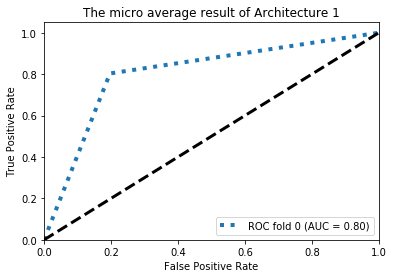

The average ROC is: 0.8032183445640149


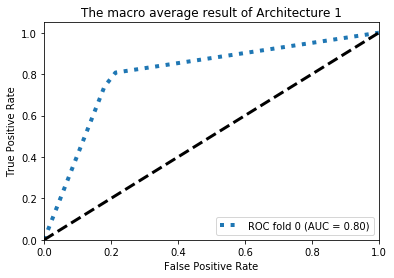

The average ROC is: 0.8031860414287877


In [24]:
lw = 3
for i in range(len(fpr_arch1)):
    plt.plot(fpr_arch1[i], tpr_arch1[i],
             label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc_macro_arch1[i]),
              linestyle=':', linewidth=4)


plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('The micro average result of Architecture 1')
plt.legend(loc="lower right")
plt.show()
print("The average ROC is:" ,np.mean(roc_auc_macro_arch1))


for i in range(len(fpr_all_arch1)):
    plt.plot(fpr_all_arch1[i], tpr_all_arch1[i],
             label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc_macro_all_arch1[i]),
              linestyle=':', linewidth=4)

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('The macro average result of Architecture 1')
plt.legend(loc="lower right")
plt.show()

print("The average ROC is:" ,np.mean(roc_auc_macro_all_arch1))

In [46]:
import pickle
h = open('model_r1_type_2.pickle','rb')
results = pickle.load(h)
history_r1_type_2,model_r1_type_2,c_r1_type_2,f1_r1_type_2,pred_r1_type_2, resultr1_type_2, costs_1_type2, fpr_arch1_type2,tpr_arch1_type2,roc_auc_macro_arch1_type2,fpr_all_arch1_type2,tpr_all_arch1_type2,roc_auc_macro_all_arch1_type2 = results

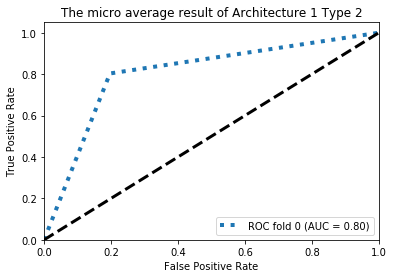

The average ROC is: 0.8032183445640149


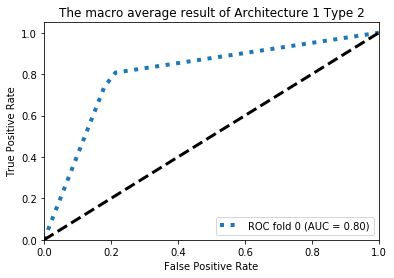

The average ROC is: 0.8031860414287877


In [26]:
for i in range(len(fpr_arch1_type2)):
    plt.plot(fpr_arch1_type2[i], tpr_arch1_type2[i],
             label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc_macro_arch1_type2[i]),
              linestyle=':', linewidth=4)


plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('The micro average result of Architecture 1 Type 2')
plt.legend(loc="lower right")
plt.show()
print("The average ROC is:" ,np.mean(roc_auc_macro_arch1_type2))


for i in range(len(fpr_all_arch1_type2)):
    plt.plot(fpr_all_arch1_type2[i], tpr_all_arch1_type2[i],
             label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc_macro_all_arch1_type2[i]),
              linestyle=':', linewidth=4)

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('The macro average result of Architecture 1 Type 2')
plt.legend(loc="lower right")
plt.show()

print("The average ROC is:" ,np.mean(roc_auc_macro_all_arch1_type2))

### Architecture 2

In [27]:
from keras.layers import GRU

def arch2_type1(X_train,X_test,y_train_ohe,y_test_ohe,v,e):
    rnn = Sequential()
    rnn.add(embedding_layer)
    rnn.add(GRU(100,dropout=0.2, recurrent_dropout=0.2))
    rnn.add(Dense(NUM_CLASSES, activation='sigmoid'))
    
    # Let's train the model 
    rnn.compile(loss='binary_crossentropy',
                  optimizer='Adam',
                  metrics=['accuracy'])

    bath_size = 32
    history = rnn.fit(X_train, y_train_ohe, batch_size=32, 
                      epochs=e, verbose=v,
                      validation_data=(X_test,y_test_ohe),# validation_steps=1,
                      callbacks=[EarlyStopping(monitor='val_loss', patience=3)]
                     )
    pred = np.round(np.argmax(rnn.predict(X_test),axis=1))
    c = accuracy_score(np.round(np.argmax(y_test_ohe,axis =1)), pred)
    f1 = f1_score(np.round(np.argmax(y_test_ohe,axis =1)), pred)
    
    result = np.round(rnn.predict(X_test))
    
    
    return history,rnn,c,f1,pred, result

In [ ]:
# This cell ran on diferent machine
history_2,model_2,c_2,f1_2,pred_2, result2 = arch2_type1(X_train,X_test,y_train_ohe,y_test_ohe,1,20)


In [28]:
import pickle
h = open('model_2.pickle','rb')
results = pickle.load(h)
history_2,model_2,c_2,f1_2,pred_2, result2 = results

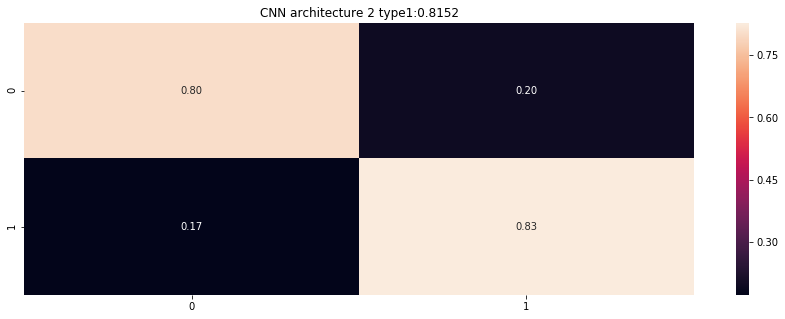

In [29]:
cm2 = summarize_net(model_2, X_test, y_test, title_text='CNN architecture 2 type1:')

### Architecture 2 type 2

In [30]:
def arch2_type2(X_train,X_test,y_train_ohe,y_test_ohe,v,e):
    rnn = Sequential()
    rnn.add(embedding_layer)
    rnn.add(GRU(100,dropout=0.2, recurrent_dropout=0.2))
    rnn.add(Dense(NUM_CLASSES, activation='sigmoid'))
    rnn.add(Dense(NUM_CLASSES, activation='sigmoid'))
    
    # Let's train the model 
    rnn.compile(loss='binary_crossentropy',
                  optimizer='Adam',
                  metrics=['accuracy'])

    bath_size = 32
    history = rnn.fit(X_train, y_train_ohe, batch_size=32, 
                      epochs=e, verbose=v,
                      validation_data=(X_test,y_test_ohe),# validation_steps=1,
                      callbacks=[EarlyStopping(monitor='val_loss', patience=3)]
                     )
    pred = np.round(np.argmax(rnn.predict(X_test),axis=1))
    c = accuracy_score(np.round(np.argmax(y_test_ohe,axis =1)), pred)
    f1 = f1_score(np.round(np.argmax(y_test_ohe,axis =1)), pred)
    
    result = np.round(rnn.predict(X_test))
    
    return history,rnn,c,f1,pred, result

In [ ]:
# This cell ran on diferent machine
history_2_type_2,model_2_type_2,c_2_type_2,f1_2_type_2,pred_2_type_2, result2_type_2 = arch2_type2(X_train,X_test,y_train_ohe,y_test_ohe,1,20)


In [31]:
import pickle
h = open('model_2_type_2.pickle','rb')
results = pickle.load(h)
history_2_type_2,model_2_type_2,c_2_type_2,f1_2_type_2,pred_2_type_2, result2_type_2 = results

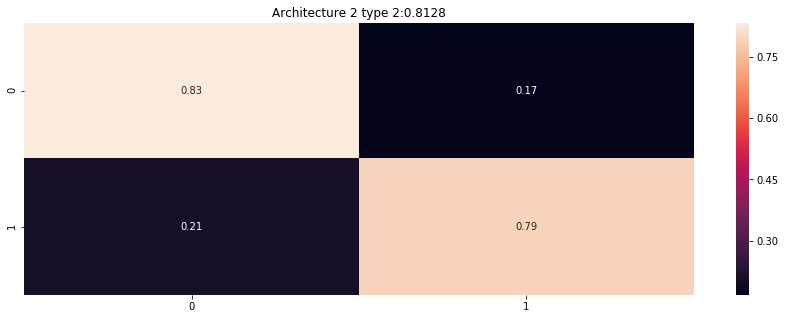

In [32]:
cm2_type2 = summarize_net(model_2_type_2, X_test, y_test, title_text='Architecture 2 type 2:')

### Visualizing the performance using ROC and AUC

In [ ]:
costs_2 = []
costs_2_type2 = []
ref = 1
#Create some variable to save each k-fold value
fpr_arch2 = []
tpr_arch2 = []
roc_auc_macro_arch2 = []
fpr_all_arch2 = []
tpr_all_arch2 = []
roc_auc_macro_all_arch2 = []
fpr_arch2_type2 = []
tpr_arch2_type2 = []
roc_auc_macro_arch2_type2 = []
fpr_all_arch2_type2 = []
tpr_all_arch2_type2 = []
roc_auc_macro_all_arch2_type2 = []

X_train_temp = X_train
y_train_temp = keras.utils.to_categorical(y_train, n_classes)
X_test_temp = X_test
y_test_temp = keras.utils.to_categorical(y_test, n_classes)

# take cost
history2,model2,c2,f1_2,pred2,result2 = arch2_type1(X_train_temp,X_test_temp,y_train_temp,y_test_temp,1,20) # last two are verbose and epochs
costs_2.append(c2)
print(mt.confusion_matrix(np.round(np.argmax(y_test_temp,axis =1)),pred2), "=>", c2)

history_2_type_2,model_2_type_2,c_2_type_2,f1_2_type_2,pred_2_type_2, result2_type_2 = arch2_type2(X_train_temp,X_test_temp,y_train_temp,y_test_temp,1,20) # last two are verbose and epochs
costs_2_type2.append(c_2_type_2)
# print confusion matrix
print(mt.confusion_matrix(np.round(np.argmax(y_test_temp,axis =1)),pred_2_type_2), "=>", c_2_type_2)

#ROC
y_score2 =result2
y_score2_type2 = result2_type_2

# Compute ROC curve and ROC area for each class
fpr2 = dict()
tpr2 = dict()
roc_auc2 = dict()
for i in range(n_classes):
    fpr2[i], tpr2[i], _ = roc_curve(y_test_temp[:, i], y_score2[:, i])
    roc_auc2[i] = auc(fpr2[i], tpr2[i])
# Compute micro-average ROC curve and ROC area
fpr2["micro"], tpr2["micro"], _ = roc_curve(y_test_temp.ravel(), y_score2.ravel())
roc_auc2["micro"] = auc(fpr2["micro"], tpr2["micro"])
fpr_arch2.append(fpr2["micro"])
tpr_arch2.append(tpr2["micro"])
roc_auc_macro_arch2.append(roc_auc2["micro"])
# Compute macro-average ROC curve and ROC area
lw = 3
# First aggregate all false positive rates
all_fpr2 = np.unique(np.concatenate([fpr2[i] for i in range(n_classes)]))
# Then interpolate all ROC curves at this points
mean_tpr2 = np.zeros_like(all_fpr2)
for i in range(n_classes):
    mean_tpr2 += interp(all_fpr2, fpr2[i], tpr2[i])
# Finally average it and compute AUC
mean_tpr2 /= n_classes
fpr2["macro"] = all_fpr2
tpr2["macro"] = mean_tpr2
roc_auc2["macro"] = auc(fpr2["macro"], tpr2["macro"])
fpr_all_arch2.append(fpr2["macro"])
tpr_all_arch2.append(tpr2["macro"])
roc_auc_macro_all_arch2.append(roc_auc2["macro"])
ref+=1
print(costs_2)

fpr2_type2 = dict()
tpr2_type2 = dict()
roc_auc2_type2 = dict()
for i in range(n_classes):
    fpr2_type2[i], tpr2_type2[i], _ = roc_curve(y_test_temp[:, i], y_score2_type2[:, i])
    roc_auc2_type2[i] = auc(fpr2_type2[i], tpr2_type2[i])
# Compute micro-average ROC curve and ROC area
fpr2_type2["micro"], tpr2_type2["micro"], _ = roc_curve(y_test_temp.ravel(), y_score2.ravel())
roc_auc2_type2["micro"] = auc(fpr2_type2["micro"], tpr2_type2["micro"])
fpr_arch2_type2.append(fpr2_type2["micro"])
tpr_arch2_type2.append(tpr2_type2["micro"])
roc_auc_macro_arch2_type2.append(roc_auc2_type2["micro"])
# Compute macro-average ROC curve and ROC area
lw = 3
# First aggregate all false positive rates
all_fpr2_type2 = np.unique(np.concatenate([fpr2_type2[i] for i in range(n_classes)]))
# Then interpolate all ROC curves at this points
mean_tpr2_type2 = np.zeros_like(all_fpr2_type2)
for i in range(n_classes):
    mean_tpr2_type2 += interp(all_fpr2_type2, fpr2_type2[i], tpr2_type2[i])
# Finally average it and compute AUC
mean_tpr2_type2 /= n_classes
fpr2_type2["macro"] = all_fpr2_type2
tpr2_type2["macro"] = mean_tpr2_type2
roc_auc2_type2["macro"] = auc(fpr2_type2["macro"], tpr2_type2["macro"])
fpr_all_arch2_type2.append(fpr2_type2["macro"])
tpr_all_arch2_type2.append(tpr2_type2["macro"])
roc_auc_macro_all_arch2_type2.append(roc_auc2_type2["macro"])
ref+=1
print(costs_2_type2)

In [51]:
import pickle
h = open('model_r2.pickle','rb')
results = pickle.load(h)
history2_r,model2_r,c2_r,f1_2r,pred2_r, result2_r, costs_2, fpr_arch2,tpr_arch2,roc_auc_macro_arch2,fpr_all_arch2,tpr_all_arch2,roc_auc_macro_all_arch2 = results

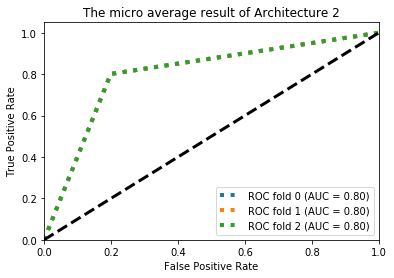

The average ROC is: 0.8009101880720104


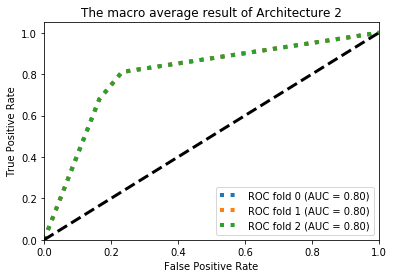

The average ROC is: 0.8009981640034699


In [34]:
for i in range(len(fpr_arch2)):
    plt.plot(fpr_arch2[i], tpr_arch2[i],
             label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc_macro_arch2[i]),
              linestyle=':', linewidth=4)


plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('The micro average result of Architecture 2')
plt.legend(loc="lower right")
plt.show()
print("The average ROC is:" ,np.mean(roc_auc_macro_arch2))


for i in range(len(fpr_all_arch2)):
    plt.plot(fpr_all_arch2[i], tpr_all_arch2[i],
             label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc_macro_all_arch2[i]),
              linestyle=':', linewidth=4)

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('The macro average result of Architecture 2')
plt.legend(loc="lower right")
plt.show()

print("The average ROC is:" ,np.mean(roc_auc_macro_all_arch2))

In [35]:
import pickle
h = open('model_r2_type_2.pickle','rb')
results = pickle.load(h)
history_r2_type_2,model_r2_type_2,c_r2_type_2,f1_r2_type_2,pred_r2_type_2, resultr2_type_2, costs_2_type_2, fpr_arch2_type2,tpr_arch2_type2,roc_auc_macro_arch2_type2,fpr_all_arch2_type2,tpr_all_arch2_type2,roc_auc_macro_all_arch2_type2 = results

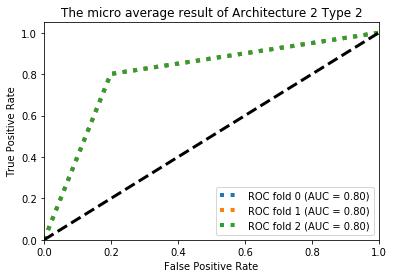

The average ROC is: 0.8009101880720104


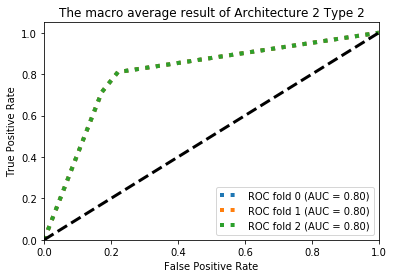

The average ROC is: 0.8035525848107882


In [36]:
for i in range(len(fpr_arch2_type2)):
    plt.plot(fpr_arch2_type2[i], tpr_arch2_type2[i],
             label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc_macro_arch2_type2[i]),
              linestyle=':', linewidth=4)


plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('The micro average result of Architecture 2 Type 2')
plt.legend(loc="lower right")
plt.show()
print("The average ROC is:" ,np.mean(roc_auc_macro_arch2_type2))


for i in range(len(fpr_all_arch2_type2)):
    plt.plot(fpr_all_arch2_type2[i], tpr_all_arch2_type2[i],
             label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc_macro_all_arch2_type2[i]),
              linestyle=':', linewidth=4)

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('The macro average result of Architecture 2 Type 2')
plt.legend(loc="lower right")
plt.show()

print("The average ROC is:" ,np.mean(roc_auc_macro_all_arch2_type2))

When we compare Architecture 1 and 2 using ROC and Area under the curve their performance is more or less similar. We will now add a second recurrent chain to our Architecture 1 Type 1 below.

### Architecture 3

In [37]:
def arch3(X_train,X_test,y_train_ohe,y_test_ohe,v,e):
    rnn = Sequential()
    rnn.add(embedding_layer)
    rnn.add(LSTM(100,dropout=0.2, recurrent_dropout=0.2,return_sequences=True))
    rnn.add(LSTM(100,dropout=0.2, recurrent_dropout=0.2))
    rnn.add(Dense(NUM_CLASSES, activation='sigmoid'))
   
    # Let's train the model 
    rnn.compile(loss='binary_crossentropy',
                  optimizer='Adam',
                  metrics=['accuracy'])

    bath_size = 32
    history = rnn.fit(X_train, y_train_ohe, batch_size=32, 
                      epochs=e, verbose=v,
                      validation_data=(X_test,y_test_ohe),# validation_steps=1,
                      callbacks=[EarlyStopping(monitor='val_loss', patience=3)]
                     )
    pred = np.round(np.argmax(rnn.predict(X_test),axis=1))
    c = accuracy_score(np.round(np.argmax(y_test_ohe,axis =1)), pred)
    f1 = f1_score(np.round(np.argmax(y_test_ohe,axis =1)), pred)
    
    result = np.round(rnn.predict(X_test))
    
    
    return history,rnn,c,f1,pred, result

In [ ]:
# This cell ran on diferent machine
history_3,model_3,c_3,f1_3,pred_3,result_3 = arch3(X_train,X_test,y_train_ohe,y_test_ohe,1,20)

In [38]:
import pickle
h = open('model_3.pickle','rb')
results = pickle.load(h)
history_3,model_3,c_3,f1_3,pred_3, result3 = results

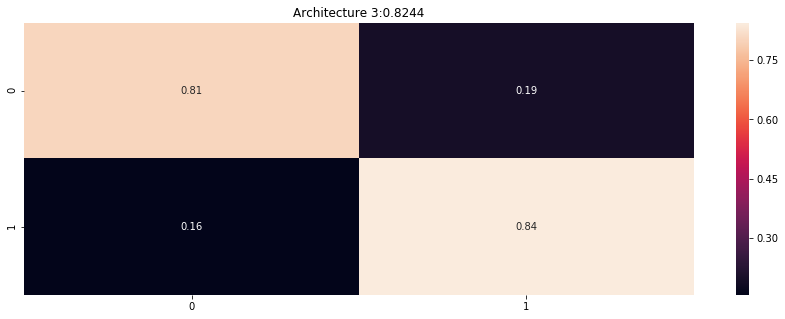

In [39]:
cm3 = summarize_net(model_3, X_test, y_test, title_text='Architecture 3:')

### Visualizing the performance using ROC and AUC

In [ ]:
costs_3 = []
ref = 1
#Create some variable to save each k-fold value
fpr_arch3 = []
tpr_arch3 = []
roc_auc_macro_arch3 = []
fpr_all_arch3 = []
tpr_all_arch3 = []
roc_auc_macro_all_arch3 = []
X_train_temp = X_train
y_train_temp = keras.utils.to_categorical(y_train, n_classes)
X_test_temp = X_test
y_test_temp = keras.utils.to_categorical(y_test, n_classes)

# take cost
history3,model3,c3,f1_3,pred3,result3 = arch3(X_train_temp[:100],X_test_temp[:100],y_train_temp[:100],y_test_temp[:100],1,1) # last two are verbose and epochs
costs_3.append(c3)
# print confusion matrix
print(mt.confusion_matrix(np.round(np.argmax(y_test_temp,axis =1)),pred3), "=>", c3)

#ROC
y_score =result3
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_temp[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_temp.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
fpr_arch3.append(fpr["micro"])
tpr_arch3.append(tpr["micro"])
roc_auc_macro_arch3.append(roc_auc["micro"])
# Compute macro-average ROC curve and ROC area
lw = 3
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])
# Finally average it and compute AUC
mean_tpr /= n_classes
fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])
fpr_all_arch3.append(fpr["macro"])
tpr_all_arch3.append(tpr["macro"])
roc_auc_macro_all_arch3.append(roc_auc["macro"])
ref+=1
print(costs_3)

In [40]:
import pickle
h = open('model_3r.pickle','rb')
results = pickle.load(h)
history3_r,model3_r,c3_r,f1_3r,pred3_r,result3_r, costs_3, fpr_arch3,tpr_arch3,roc_auc_macro_arch3,fpr_all_arch3,tpr_all_arch3,roc_auc_macro_all_arch3 = results

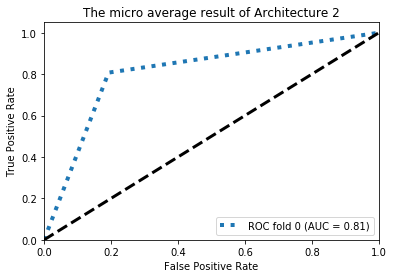

The average ROC is: 0.8073569345268028


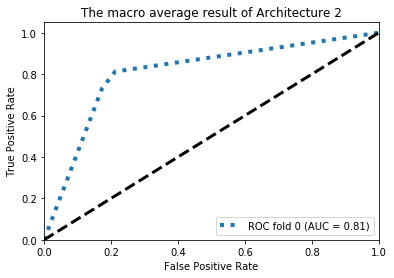

The average ROC is: 0.8073190251170917


In [41]:
for i in range(len(fpr_arch3)):
    plt.plot(fpr_arch3[i], tpr_arch3[i],
             label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc_macro_arch3[i]),
              linestyle=':', linewidth=4)


plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('The micro average result of Architecture 2')
plt.legend(loc="lower right")
plt.show()
print("The average ROC is:" ,np.mean(roc_auc_macro_arch3))


for i in range(len(fpr_all_arch3)):
    plt.plot(fpr_all_arch3[i], tpr_all_arch3[i],
             label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc_macro_all_arch3[i]),
              linestyle=':', linewidth=4)

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('The macro average result of Architecture 2')
plt.legend(loc="lower right")
plt.show()

print("The average ROC is:" ,np.mean(roc_auc_macro_all_arch3))

### Visualizing final results

In [53]:
print ('Accuracy of Arcitecure 1 type 1:', c_1)
print ('Accuracy of Arcitecure 1 type 2:', c_1_type_2)
print ('Accuracy of Arcitecure 2 type 1:', c_2)
print ('Accuracy of Arcitecure 2 type 2:', c_2_type_2)
print ('Accuracy of Architecture 3:', c_3)

Accuracy of Arcitecure 1 type 1: 0.8076837976465855
Accuracy of Arcitecure 1 type 2: 0.8091521673539174
Accuracy of Arcitecure 2 type 1: 0.8034999497133661
Accuracy of Arcitecure 2 type 2: 0.8023332998089108
Accuracy of Architecture 3: 0.8111435180529015


In [54]:
df2 = pd.DataFrame()
df2['Arch1_type1'] = [c_1]
df2['Arch1_type2'] = [c_1_type_2]
df2['Arch2_type1'] = [c_2]
df2['Arch2_type2'] = [c_2_type_2]
df2['Arch3'] = [c_3]

[Text(0, 0.5, 'Accuracy Score')]

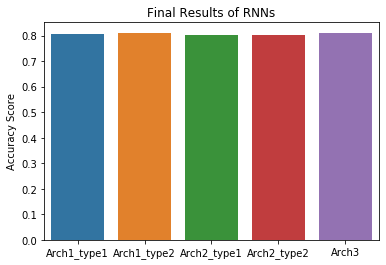

In [55]:
labels = list(df2.columns)
Perf_optimization = sns.barplot(labels, df2.iloc[0,:])
#plt.subplot(1,2,2)
plt.title('Final Results of RNNs')
Perf_optimization.set(ylabel="Accuracy Score")

We have visualized the results of all the RNNs that we trained using Receiver Operating Characteristics and Area under the curve. We have also visualized their final results in terms of Accuracy. Both the models in Architecture 1 and Architecture 2 have area of 0.80 under the curve and their accuracy also is about 80% for all the models. The model for Architecture 3 has area under the curve of 0.81 and slightly better accuracy than rest of the models<br>
So we think that Architecture 3 is our best model.

## Plotting Loss and Accuracy

Text(0.5, 0, 'epochs')

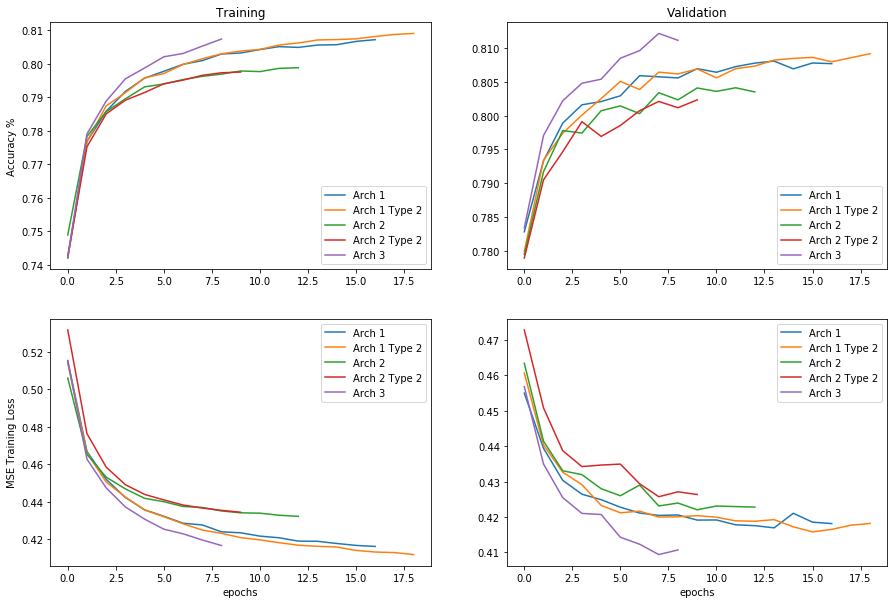

In [42]:
from matplotlib import pyplot as plt

%matplotlib inline

legends=['Arch 1','Arch 1 Type 2','Arch 2','Arch 2 Type 2','Arch 3']
plt.figure(figsize=(15,10))
plt.subplot(2,2,1)
plt.plot(history_1.history['accuracy'])
plt.plot(history_1_type_2.history['accuracy'])
plt.plot(history_2.history['acc'])
plt.plot(history_2_type_2.history['acc'])
plt.plot(history_3.history['accuracy'])
plt.legend(legends)

plt.ylabel('Accuracy %')
plt.title('Training')
plt.subplot(2,2,2)
plt.plot(history_1.history['val_accuracy'])
plt.plot(history_1_type_2.history['val_accuracy'])
plt.plot(history_2.history['val_acc'])
plt.plot(history_2_type_2.history['val_acc'])
plt.plot(history_3.history['val_accuracy'])
plt.legend(legends)
plt.title('Validation')

plt.subplot(2,2,3)
plt.plot(history_1.history['loss'])
plt.plot(history_1_type_2.history['loss'])
plt.plot(history_2.history['loss'])
plt.plot(history_2_type_2.history['loss'])
plt.plot(history_3.history['loss'])
plt.ylabel('MSE Training Loss')
plt.legend(legends)
plt.xlabel('epochs')

plt.subplot(2,2,4)
plt.plot(history_1.history['val_loss'])
plt.plot(history_1_type_2.history['val_loss'])
plt.plot(history_2.history['val_loss'])
plt.plot(history_2_type_2.history['val_loss'])
plt.plot(history_3.history['val_loss'])
plt.legend(legends)
plt.xlabel('epochs')

From the graphs above, we can see that 20 epochs for each model are sufficient for our data set. Yet some models get converged after 8 epochs

### Exceptional Work T-SNE
We used t-SNE to visualize the word embeddings of a subset of words in our vocabulary.

In [29]:
%%time
from sklearn.manifold import TSNE
tsne = TSNE(n_components = 2, verbose = 1, perplexity = 50, n_iter = 250)

CPU times: user 64.6 ms, sys: 17.2 ms, total: 81.8 ms
Wall time: 81.3 ms


In [30]:
# This cell ran on ManeFrame
'''from sklearn.manifold import TSNE
tsne = TSNE(n_components = 2, verbose = 1, perplexity = 50, n_iter = 250)

temp = tsne.fit_transform(np.array(embedding_matrix))

np.save('tsne.npy',temp)'''


"from sklearn.manifold import TSNE\ntsne = TSNE(n_components = 2, verbose = 1, perplexity = 50, n_iter = 250)\n\ntemp = tsne.fit_transform(np.array(embedding_matrix))\n\nnp.save('tsne.npy',temp)"

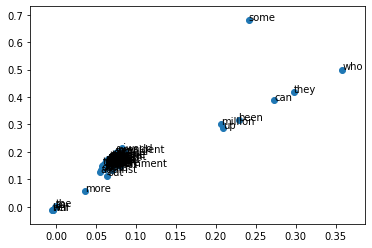

In [52]:
# T-SNE ran on ManeFrame
temp = np.load('tsne.npy')
fig, ax = plt.subplots()
num = 100
ax.scatter(temp[:,0][0:num], temp[:,1][0:num])
for i, txt in enumerate(name[0:num]):
    ax.annotate(txt, (temp[:,0][0:num][i], temp[:,1][0:num][i]))

In the graph above we can see that 100 most common words, composed "line". From the terminal points, we can see words such as "some", "who", "they", "can", "more". Those words did not cluster. Two small clusters are observed, one contains "up", "on" "been" words, and another "the", "then", "as". The later is visible in the plot of 30 most common words. Now let's take a look at the biggest cluster.  

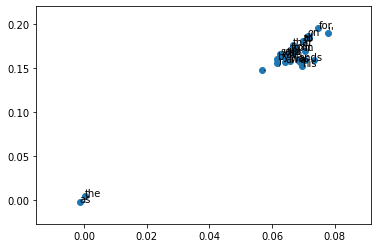

In [15]:
#Let's take a closer look
temp = np.load('tsne.npy')
fig, ax = plt.subplots()
num = 30
ax.scatter(temp[:,0][0:num], temp[:,1][0:num])
for i, txt in enumerate(name[0:num]):
    ax.annotate(txt, (temp[:,0][0:num][i], temp[:,1][0:num][i]))

(0.12, 0.22)

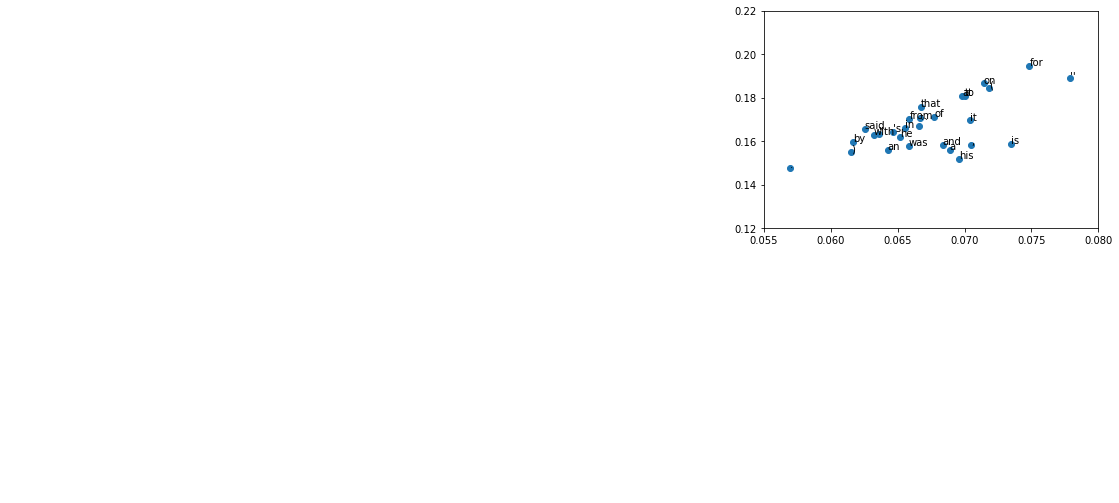

In [16]:
fig, ax = plt.subplots()
num = 30
ax.scatter(temp[:,0][0:num], temp[:,1][0:num])
for i, txt in enumerate(name[0:num]):
    ax.annotate(txt, (temp[:,0][0:num][i], temp[:,1][0:num][i]))
ax.set_xlim(0.055,0.080)
ax.set_ylim(0.12,0.220)

The 30 most common words used in the tweets are (not surprisingly) the prepositions, postpositions, and other short words as well as period and quotation marks. The only verb that we can distinguish is "said". Those words are clustered together because of the similarity measures between pairs of instances, which means that they appeared in many tweets. As the tweets are based on casual language.  